# Problem

We have a search browser, where a user inputs a query (a string), and a model outputs various images
We have a dataset with such querries and returned images as well as other features regarding the image.
We also have labels supposed trustworthy with a boolean label assessing whether the returned image was relevant or not.

## Exploratory phase

First let us have a look at the variables to understand:
- what they represent
- the possible values
- how to deal with NaN
- should we preproces or drop them.
- if they are correlated.

As this is quite a lengthy process, we will do so in a separate notebook [data_exploration.ipynb](data_exploration.ipynb) for the sake of cleanliness.

Based on the data exploration, we can draw the following conclusions

Target variable is highly unbalanced: only 4% of the dataset provided in training correspond to relevant cases. 
We must take this into account in the study of features, since potentially a feature with 96% null values could indicate exactly the relevance of a given result.

0. **query**: a one word text query that led to the list of results
1. **url_page**: this variable shows the address where the URL was found. We can potentially derive keywords from it in some cases
2. **title** of the webpage, also quite a valuable feature that needs a decent amount of preprocessing.
3. **source** domain, redundant with the url (as it is extracted from it, which can be done through a regexp)
4. **alt**: alternative text for the image, can be used as additional text to measure adequation with the query
5. **src** of the image... This could be part of the training: I could build a crawler to download them, then use CV network embedding as part of the training... Yet since there are 500k images to download, and I could check many are missing, maybe it would be overkill to start this classification task
6. **crossorigin** is mostly null... And yet it is null only in 2% of cases when is_relevant = 1, therefore this is a rather relevant feature. Alone it could provide up to 98% accuracy. Since there are only 3 possible values including an overwhelming number of "anonymous" value, we can convert this to a simple binary variable with False if the value is null and True otherwise (there are not enough training sample to use it any other way)
7. **height** contains 60% null values which is null, but the remaining 40% is interesting. A quick plot shows that values are mostly between -100 and 1000. It would make sense to work them out: ignore any value below 0 or above 1500 and flag them as NaN, then normalize the values, as the distance from the mean in itself is a strong information (cf. chart)
8. **ismap** is very similar to crossorigin... But it  contains only 10 non null values among which only 2 are "relevant"... This is not enough for any ML algorithm to draw conclusions on. Let us remove it completely
9. **loading** contains 80% null values, but most values that are of type "lazy" are relevant. Here it would make sense to convert this into 4 categories: lazy, eager, auto and everything else (including null) can be flagged as "unknown"
10. **longdesc** is often null or empty. It corresponds to URLs with very few readable words... Let us just convert this to a binary value: True if the value is not null and contains at least 5 chars, False otherwise
11. **referrer_policy** seems to be an extremely strong indicator... Although it only enables us to spot 7 cases... We can actually create a variable True if "no-referer", False in other cases
12. **sizes** is null in 80% cases for... and is not super interpretable. Ideally preprocessing could be applied to extract the proper numerical values. Yet it seems highly difficult to find an algorithm to really understand these as units differ widely and so do formats. Many numbers are expressed and finding a systematic one of interest is not easy OOB. Let us ues a boolean conversion for now. It is also a bit redundant with the height sementically.
13. **srcset** is also a variable difficult to understand. It is null only in 3% of relevant images, yet values seem to be only "src_set". Other values come mostly from wikimedia in this dataset. The boolean variable seems once more the appropriate solution. Given the other variables we picked that satisfy these conditions and the relatively small semantic significance of this, let us get rid of this variable alltogether.
14. **width** very similar behavior to height
15. **class** is a rather interesting and informative value, only 50% of values are null. There must be some pre-treatment to be done as the CSS class are built with several words separated by spaces. We went and selected 30 possible classes to be labeled from 0 to 29, the NaN flag being a different one, and all others another label yet.
16. **style** we extact css-class through regexp, then follow a similar preprocessing than for class. In the end we are left with 35 labels and the rest is either another label or nan
17. **tree_path** similar to class
18. **deg** can be used as is: categorical variable with 3 possible values
19. **text_tag** can be used as is: categorical variable with many possible values
20. **text**: must be processed
21. **id**: a very precised id used for db storage. We can drop it


Hence we must build a preprocessor for 1,2,4,11, 20 for text values, 6,9,10,12,15,16, 17 as a boolean/catgorical var, 7,14 as a numerical feature, remove columns 3, 5, 8, 13, 21
We will use directly features 18,19

12, 15 could potentially be improved with further work.

As for the text processor, how are we going to procede?
 - option 1: include a text embedding corresponding to a NLP-DL algorithm embedding of the corresponding sentence... This is possible but with this we have a lot more data. With 3 text fields, each resulting of an embedding size of size 256, that's 768 columns variables. If we throw in the others that's roughly 800 features. We only have 4% of 100k rows positive elements that's 4*100k/100 = 4000. We have a ratio valid samples/ features = 4000/800 = 5... That's too small
 - option2: we try and train our own NN to generate an embedding for all the text and other values available to produce the final binary classification. This is possible, and we can use pretrained NLP networks for this... But it seems a bit overkill for a binary classification where boosting algorithms might be faster, allow for more explainability, and scalability.
 - option 3: we use pre-trained embedding NN as in option 1, but instead of introducing the full-emebedding in the dataset we will just compute cosine similarity between vectors: one distance for cos(query, title), cos(query, alt), cos(query, text), cos(alt, text), cos(alt, url), cos(title, text). This way we introduce only 6 new features. We can remove abreviations and numbers but add a feature if terms from the query are in the text


Once we're done completely, we should apply the transformations from above and check for correlations, for exemple using dython libraries to use continuous-categorical and categorical-categorical comparisons metrics (cramer's V, point biserial, theil's u, and correlations)

## Text embedding

We start with some exploration around the best way to embed. Again to make things clearer, we share this exploration separately in [text_embedding_exploration.ipynb](text_embedding_exploration.ipynb).

We derive a transformer object compatible with sklearn interface availabel in [text_processor.py](src/preprocessors/text_processor.py)

In [4]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1050'

In [5]:
from src.preprocessors.text_processor import CustomTextTransformer
import pandas as pd
import pickle

# create, fit and apply the text_preprocessor
ctt = CustomTextTransformer()
df = pd.read_feather("train.feather")
ctt.fit(df)
tmp = ctt.transform(df)

# backing up the result since it took 1h to run on my machine.
tmp.to_pickle("ctt_processed_df.pickle")
with open("ctt_fitted.pickled", "wb") as f:
    pickle.dump(ctt, f)

05:09:20 INFO:Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2
05:09:20 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/modules.json HTTP/1.1" 200 0
05:09:20 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/config_sentence_transformers.json HTTP/1.1" 200 0
05:09:20 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/README.md HTTP/1.1" 200 0
05:09:20 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/modules.json HTTP/1.1" 200 0
05:09:20 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/sentence_bert_config.json HTTP/1.1" 200 0
05:09:20 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/config.json HTTP/1.1" 200 0
05:09:20 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/pa

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

05:09:37 DEBUG:Attempting to release lock 2329348689920 on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\5d716de760acbdc09e79a11e718c5606e0812b6aeb76c6664cba876d174e3ecd.lock
05:09:37 DEBUG:Lock 2329348689920 released on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\5d716de760acbdc09e79a11e718c5606e0812b6aeb76c6664cba876d174e3ecd.lock
05:09:37 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
05:09:37 DEBUG:Attempting to acquire lock 2329298905472 on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\7410db66f06de178beeadfdd11b1fc241b04f683.lock
05:09:37 DEBUG:Lock 2329298905472 acquired on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\7410db66f06de178beeadfdd11b1fc241b04f683.lock
05:09:37 DEB

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

05:09:37 DEBUG:Attempting to release lock 2329298905472 on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\7410db66f06de178beeadfdd11b1fc241b04f683.lock
05:09:37 DEBUG:Lock 2329298905472 released on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\7410db66f06de178beeadfdd11b1fc241b04f683.lock
05:09:37 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/vocab.txt HTTP/1.1" 200 0
05:09:38 DEBUG:Attempting to acquire lock 2329348874896 on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
05:09:38 DEBUG:Lock 2329348874896 acquired on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
05:09:38 DEBUG:https://huggingface.co:443 "GET /sentence-transformers/pa

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

05:09:38 DEBUG:Attempting to release lock 2329348874896 on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
05:09:38 DEBUG:Lock 2329348874896 released on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
05:09:38 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/tokenizer.json HTTP/1.1" 200 0
05:09:38 DEBUG:Attempting to acquire lock 2329298910464 on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\40c4a0f6c414c8218190234bbce9bf4cc04fa3ac.lock
05:09:38 DEBUG:Lock 2329298910464 acquired on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\40c4a0f6c414c8218190234bbce9bf4cc04fa3ac.lock
05:09:38 DEBUG:https://huggingface.co:443 "GET /sentence-transforme

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

05:09:38 DEBUG:Attempting to release lock 2329298910464 on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\40c4a0f6c414c8218190234bbce9bf4cc04fa3ac.lock
05:09:38 DEBUG:Lock 2329298910464 released on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\40c4a0f6c414c8218190234bbce9bf4cc04fa3ac.lock
05:09:38 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/added_tokens.json HTTP/1.1" 404 0
05:09:39 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/special_tokens_map.json HTTP/1.1" 200 0
05:09:39 DEBUG:Attempting to acquire lock 2329298910464 on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\e7b0375001f109a6b8873d756ad4f7bbb15fbaa5.lock
05:09:39 DEBUG:Lock 2329298910464 acquired on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

05:09:39 DEBUG:Attempting to release lock 2329298910464 on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\e7b0375001f109a6b8873d756ad4f7bbb15fbaa5.lock
05:09:39 DEBUG:Lock 2329298910464 released on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\e7b0375001f109a6b8873d756ad4f7bbb15fbaa5.lock
05:09:39 DEBUG:https://huggingface.co:443 "GET /api/models/sentence-transformers/paraphrase-MiniLM-L6-v2/revision/main HTTP/1.1" 200 2061
05:09:39 DEBUG:Starting new HTTPS connection (1): huggingface.co:443
05:09:39 DEBUG:https://huggingface.co:443 "HEAD /sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/77d17f9171686731e768ee6a1c5c573191f0f2a0/1_Pooling/config.json HTTP/1.1" 200 0
05:09:39 DEBUG:Attempting to acquire lock 2329348870144 on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\d1514c3162bbe87b343f565fadc62e6c06f04f03.lock
05:09:39 

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

05:09:39 DEBUG:Attempting to release lock 2329348870144 on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\d1514c3162bbe87b343f565fadc62e6c06f04f03.lock
05:09:39 DEBUG:Lock 2329348870144 released on C:\Users\benja\.cache\huggingface\hub\.locks\models--sentence-transformers--paraphrase-MiniLM-L6-v2\d1514c3162bbe87b343f565fadc62e6c06f04f03.lock
05:09:43 INFO:lemmatizing query


05:10:16 INFO:lemmatizing url_page


05:11:40 INFO:lemmatizing alt


05:12:21 INFO:lemmatizing title


05:13:19 INFO:lemmatizing text


05:16:41 INFO:checking if query in url_page
100%|██████████| 607844/607844 [00:01<00:00, 599461.58it/s]
05:16:47 INFO:checking if query in alt
100%|██████████| 607844/607844 [00:01<00:00, 478520.67it/s]
05:16:49 INFO:checking if query in title
100%|██████████| 607844/607844 [00:01<00:00, 540961.20it/s]
05:16:52 INFO:checking if query in text
100%|██████████| 607844/607844 [00:01<00:00, 389359.04it/s]
05:16:54 INFO:undoing lemma stage for title
05:16:56 INFO:undoing lemma stage for text
05:17:06 INFO:embedding query


Batches:   0%|          | 0/18996 [00:00<?, ?it/s]

05:23:58 INFO:embedding url_page


Batches:   0%|          | 0/18996 [00:00<?, ?it/s]

05:33:52 INFO:embedding alt


Batches:   0%|          | 0/18996 [00:00<?, ?it/s]

05:41:36 INFO:embedding title


Batches:   0%|          | 0/18996 [00:00<?, ?it/s]

05:51:11 INFO:embedding text


Batches:   0%|          | 0/18996 [00:00<?, ?it/s]

06:09:49 INFO:computing similarity query-url_page
06:10:03 INFO:computing similarity query-alt
06:10:17 INFO:computing similarity query-title
06:10:22 INFO:computing similarity query-text


In [6]:
tmp

,source,src,crossorigin,height,ismap,loading,longdesc,referrerpolicy,sizes,srcset,...,id,is_relevant,query_in_url_page,query_in_alt,query_in_title,query_in_text,similarity query-url_page,similarity query-alt,similarity query-title,similarity query-text
0,bank-routing.org,https://bank-routing.org/img/logo.png,None,None,None,None,None,None,None,None,...,3f5e067733178cc0f4b3a97cfc9c62e1,0,1,0,1,0,0.635109,0.152859,0.327746,0.152378
1,bank-routing.org,https://bank-routing.org/img/routing_numbers/r...,None,None,None,None,None,None,None,None,...,fe64168fa7afeefa73708113c4bc2730,1,1,1,1,1,0.635109,0.532166,0.327746,0.249405
2,bank-routing.org,https://images.dmca.com/Badges/dmca_protected_...,None,None,None,None,None,None,None,None,...,5b5c3b6560ae158bf7ecd09f5ead1841,0,1,0,1,0,0.635109,0.149922,0.327746,NaN
3,bank-routing.org,https://pixel.quantserve.com/pixel/p-1meCEwxYU...,None,1,None,None,None,None,None,None,...,91fe71b49453d9037769b5a99c6f0856,0,1,0,1,1,0.635109,0.230863,0.327746,0.407050
4,gobankingrates.com,https://cdn.gobankingrates.com/wp-content/them...,None,None,None,None,None,None,None,None,...,021b4f809739c93f6ff913ce7389a9c9,0,0,0,0,0,0.192832,0.127805,0.258014,0.303037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607839,zimbio.com,https://www3.pictures.zimbio.com/gi/Love+Gilda...,None,None,None,None,None,None,None,None,...,be4600496574da8220ac4aa5a0e18b9c,0,1,1,1,1,0.834869,0.735188,0.836518,0.390447
607840,zimbio.com,https://pixel.quantserve.com/pixel/p-124BfeS-b...,None,1,None,None,None,None,None,None,...,5ec3a478dfd3b8964397a5c92d08c2a6,0,1,0,1,1,0.834869,0.305505,0.836518,0.305585
607841,zimbio.com,https://www.zimbio.com/images/logo_Zimbio_32x8...,None,None,None,None,None,None,None,None,...,dfb4c61ec0bb680193826a201bce9ceb,0,1,0,1,0,0.834869,NaN,0.836518,0.651888
607842,zimbio.com,https://www1.pictures.zimbio.com/gi/Love+Gilda...,None,None,None,None,None,None,None,None,...,25271b2c3b2aba44d97080ad78cf62cc,0,1,1,1,1,0.834869,0.735188,0.836518,0.390447


In [7]:
# reading from file
# with open("ctt_processed_df.pickle", "rb") as f:
#     tmp = pickle.load(f)
# tmp

## Categorical + Numerical + variable removal preprocessing

NB: the elements in this notebook have been simplified so that they are easier to read and interpret. Extensive testing has been run for each of these custom preprocessors to ensure they work properly.
In this repository we only provide minimum testing unders [tests](tests/) for some of the following elements. With more time a full battery of tests should be built.

Also notice that the transformers called below are fully compatible with sklearn meaning instead of calling them separately as we do here we could do something neater like

```python
from sklearn.pipeline import Pipeline
from src.preprocessors.text_processor import CustomTextTransformer
from src.preprocessors.category_processor import CustomCategoricalTransformer
from src.preprocessors.numerical_processor import CustomNumericalPreprocessor
from src.preprocessors.remover_processor import CustomColumnRemoverPreprocessor
from xgboost import XGBClassifier

model = Pipeline(
    [
        ("textTransformer", CustomTextTransformer()),
        ("categoryTransformer", CustomCategoricalTransformer()),
        ("categoryTransformer", CustomCategoricalTransformer()),
        ("numericalTransformer", CustomNumericalPreprocessor()),
        ("removerTransformer", CustomColumnRemoverPreprocessor()),
        ("estimator", XGBClassifier()),
    ]
)
```

And then call the gridsearch while taking all hyperparameters of both the preprocessors and estimator in one go. But since the run takes time, and in order to see intermediary results we go through the sequence manually and only optimize the estimator's hyperparams.

In [336]:
from src.preprocessors.category_processor import CustomCategoricalTransformer
cct = CustomCategoricalTransformer()
cct.fit(tmp)
tmp2 = cct.transform(tmp)
tmp2

10:54:59 INFO:fitting for variable class
100%|██████████| 607844/607844 [00:13<00:00, 45479.30it/s] 
C:\Users\benja\AppData\Local\Temp\ipykernel_19208\1320848910.py:160: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d[
10:55:14 INFO:fitting for variable style
100%|██████████| 607844/607844 [00:10<00:00, 58100.42it/s] 
10:55:45 INFO:fitting for variable tree_path
10:55:45 INFO:fitting for variable loading
10:55:45 INFO:transforming variables crossorigin, longdesc, referrerpolicy and sizes
10:55:46 INFO:transforming variable class
10:55:49 INFO:transforming variable style
10:55:51 INFO:transforming variable tree_path
10:57:14 INFO:transforming variable loading


,source,src,crossorigin,height,ismap,longdesc,referrerpolicy,sizes,srcset,width,...,tree_path_item_button,tree_path_item_source,tree_path_item_tbody,tree_path_item_center,tree_path_item_strong,tree_path_item_font,no_loading,loading_item_lazy,loading_item_eager,loading_item_auto
0,bank-routing.org,https://bank-routing.org/img/logo.png,True,None,None,False,None,True,None,None,...,False,False,False,False,False,False,True,False,False,False
1,bank-routing.org,https://bank-routing.org/img/routing_numbers/r...,True,None,None,False,None,True,None,None,...,False,False,False,False,False,False,True,False,False,False
2,bank-routing.org,https://images.dmca.com/Badges/dmca_protected_...,True,None,None,False,None,True,None,None,...,False,False,False,False,False,False,True,False,False,False
3,bank-routing.org,https://pixel.quantserve.com/pixel/p-1meCEwxYU...,True,1,None,False,None,True,None,1,...,False,False,False,False,False,False,True,False,False,False
4,gobankingrates.com,https://cdn.gobankingrates.com/wp-content/them...,True,None,None,False,None,True,None,None,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607839,zimbio.com,https://www3.pictures.zimbio.com/gi/Love+Gilda...,True,None,None,False,None,True,None,None,...,False,False,False,False,False,False,True,False,False,False
607840,zimbio.com,https://pixel.quantserve.com/pixel/p-124BfeS-b...,True,1,None,False,None,True,None,1,...,False,False,False,False,False,False,True,False,False,False
607841,zimbio.com,https://www.zimbio.com/images/logo_Zimbio_32x8...,True,None,None,False,None,True,None,None,...,False,False,False,False,False,False,True,False,False,False
607842,zimbio.com,https://www1.pictures.zimbio.com/gi/Love+Gilda...,True,None,None,False,None,True,None,None,...,False,False,False,False,False,False,True,False,False,False


In [338]:
from src.preprocessors.numerical_processor import CustomNumericalPreprocessor
cnt = CustomNumericalPreprocessor()
cnt.fit(tmp2)
tmp3 = cnt.transform(tmp2)
tmp3

C:\Users\benja\AppData\Local\Temp\ipykernel_19208\2963382385.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return out.replace(pd.NaT, np.nan)


,source,src,crossorigin,height,ismap,longdesc,referrerpolicy,sizes,srcset,width,...,tree_path_item_button,tree_path_item_source,tree_path_item_tbody,tree_path_item_center,tree_path_item_strong,tree_path_item_font,no_loading,loading_item_lazy,loading_item_eager,loading_item_auto
0,bank-routing.org,https://bank-routing.org/img/logo.png,True,NaN,NaN,False,NaN,True,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
1,bank-routing.org,https://bank-routing.org/img/routing_numbers/r...,True,NaN,NaN,False,NaN,True,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
2,bank-routing.org,https://images.dmca.com/Badges/dmca_protected_...,True,NaN,NaN,False,NaN,True,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
3,bank-routing.org,https://pixel.quantserve.com/pixel/p-1meCEwxYU...,True,-1.048477,NaN,False,NaN,True,NaN,-0.754418,...,False,False,False,False,False,False,True,False,False,False
4,gobankingrates.com,https://cdn.gobankingrates.com/wp-content/them...,True,NaN,NaN,False,NaN,True,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607839,zimbio.com,https://www3.pictures.zimbio.com/gi/Love+Gilda...,True,NaN,NaN,False,NaN,True,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
607840,zimbio.com,https://pixel.quantserve.com/pixel/p-124BfeS-b...,True,-1.048477,NaN,False,NaN,True,NaN,-0.754418,...,False,False,False,False,False,False,True,False,False,False
607841,zimbio.com,https://www.zimbio.com/images/logo_Zimbio_32x8...,True,NaN,NaN,False,NaN,True,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
607842,zimbio.com,https://www1.pictures.zimbio.com/gi/Love+Gilda...,True,NaN,NaN,False,NaN,True,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False


In [340]:
from src.preprocessors.remover_processor import CustomColumnRemoverPreprocessor
ccrt = CustomColumnRemoverPreprocessor()
ccrt.fit(tmp)
tmp4 = ccrt.transform(tmp3)
tmp4

,crossorigin,height,longdesc,referrerpolicy,sizes,width,deg,text_tag,query_in_url_page,query_in_alt,...,tree_path_item_button,tree_path_item_source,tree_path_item_tbody,tree_path_item_center,tree_path_item_strong,tree_path_item_font,no_loading,loading_item_lazy,loading_item_eager,loading_item_auto
0,True,NaN,False,NaN,True,NaN,2.0,div,1,0,...,False,False,False,False,False,False,True,False,False,False
1,True,NaN,False,NaN,True,NaN,1.0,div,1,1,...,False,False,False,False,False,False,True,False,False,False
2,True,NaN,False,NaN,True,NaN,NaN,NaN,1,0,...,False,False,False,False,False,False,True,False,False,False
3,True,-1.048477,False,NaN,True,-0.754418,3.0,body,1,0,...,False,False,False,False,False,False,True,False,False,False
4,True,NaN,False,NaN,True,NaN,2.0,form,0,0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607839,True,NaN,False,NaN,True,NaN,3.0,div,1,1,...,False,False,False,False,False,False,True,False,False,False
607840,True,-1.048477,False,NaN,True,-0.754418,2.0,body,1,0,...,False,False,False,False,False,False,True,False,False,False
607841,True,NaN,False,NaN,True,NaN,2.0,div,1,0,...,False,False,False,False,False,False,True,False,False,False
607842,True,NaN,False,NaN,True,NaN,3.0,div,1,1,...,False,False,False,False,False,False,True,False,False,False


In [201]:
# 100 columns are a lot, but here the number of training samples makes it reasonably relevant (ratio features/samples > 5000)
sorted(tmp4.columns)

['class_item_aligncenter',
 'class_item_alignleft',
 'class_item_alignright',
 'class_item_attachment-',
 'class_item_attachment-full',
 'class_item_attachment-large',
 'class_item_attachment-post-thumbnail',
 'class_item_avia_image',
 'class_item_bbImage',
 'class_item_cloudzoom',
 'class_item_d-block',
 'class_item_default',
 'class_item_featured-image',
 'class_item_file-default',
 'class_item_full',
 'class_item_gallery-placeholder__image',
 'class_item_img-fluid',
 'class_item_img-responsive',
 'class_item_js-qv-product-cover',
 'class_item_mx-auto',
 'class_item_responsive',
 'class_item_size-',
 'class_item_size-full',
 'class_item_size-large',
 'class_item_size-post-thumbnail',
 'class_item_td-modal-image',
 'class_item_vc_single_image-img',
 'class_item_video__thumbnail',
 'class_item_visible',
 'class_item_w-100',
 'class_item_wp-post-image',
 'crossorigin',
 'deg',
 'height',
 'loading_item_auto',
 'loading_item_eager',
 'loading_item_lazy',
 'longdesc',
 'no_class',
 'no_lo

## Basic Correlation Analysis

We use dython to automatically switch to the metric best mesuring the influence of 2 variables on each other (correlation for numeric variables, but Cramer's V for categorical-categorical or Pearson's for categorical-numerical)

In [224]:
# quick correlation plot using dython with proper dtype inference
from dython import associations
# below we use "str" instead of 'category" because it makes it easier to add categories in the "associations" function
dtype_dict = {x: "str" for x in tmp2.columns if x[:10] in ["class_item", "style_item"]}
dtype_dict.update({x: "str" for x in tmp2.columns if x[:12] == "loading_item"})
dtype_dict.update({x: "str" for x in tmp2.columns if x[:14] == "tree_path_item"})
dtype_dict.update({x: "str" for x in tmp2.columns if x[:8] == "query_in"})
dtype_dict.update({x: "str" for x in tmp2.columns if x[:3] == "no_"})
dtype_dict.update(
    {
        x: "str"
        for x in tmp2.columns
        if x
        in ["deg", "referrerpolicy", "crossorigin", "longdesc", "sizes", "text_tag"]
    }
)
dtype_dict.update({x: "float" for x in tmp2.columns if x in ["height", "width"]})
dtype_dict.update({x: "float" for x in tmp2.columns if x[:16] == "similarity query"})

tmp = tmp4.astype(dtype_dict).assign(is_relevant=df.is_relevant)
corr = associations(
    tmp,
    numerical_columns=[k for k, v in dtype_dict.items() if v == "float"],
    nan_strategy="replace",
    figsize=(10,5),
    compute_only=True,
    title="correlation analysis categorical-compatible)",
)["corr"]
corr

,crossorigin,height,longdesc,referrerpolicy,sizes,width,deg,text_tag,query_in_url_page,query_in_alt,...,tree_path_item_source,tree_path_item_tbody,tree_path_item_center,tree_path_item_strong,tree_path_item_font,no_loading,loading_item_lazy,loading_item_eager,loading_item_auto,is_relevant
crossorigin,1.0,0.004107,0.0,0.0,0.007693,0.003752,0.020026,0.060237,0.003839,0.003304,...,0.0,0.002702,0.000853,0.0,0.0,0.016081,0.017112,0.000558,0.0,0.007654
height,0.004107,1.0,0.002807,0.006093,0.208121,0.650998,0.025698,0.156767,0.013428,0.080885,...,0.01604,0.041453,0.006237,0.000552,0.003948,0.099956,0.102361,0.001076,0.002884,0.087963
longdesc,0.0,0.002807,1.0,0.0,0.006331,0.000059,0.024227,0.033154,0.009583,0.001198,...,0.006136,0.002167,0.0,0.0,0.005284,0.00898,0.00861,0.0,0.0,0.0
referrerpolicy,0.0,0.006093,0.0,1.0,0.007782,0.008774,0.015686,0.0,0.001711,0.003667,...,0.008052,0.002732,0.000797,0.0,0.0,0.01064,0.010231,0.000432,0.0,0.000684
sizes,0.007693,0.208121,0.006331,0.007782,1.0,0.300007,0.061155,0.147576,0.028308,0.019251,...,0.036961,0.042403,0.022927,0.013456,0.019646,0.316117,0.330784,0.017902,0.022055,0.060459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
no_loading,0.016081,0.099956,0.00898,0.01064,0.316117,0.152567,0.04609,0.171244,0.007317,0.018906,...,0.032087,0.045133,0.039633,0.002541,0.026885,1.0,0.964312,0.163331,0.136784,0.004671
loading_item_lazy,0.017112,0.102361,0.00861,0.010231,0.330784,0.158435,0.050084,0.172711,0.013489,0.009039,...,0.030544,0.042058,0.038057,0.003848,0.025849,0.964312,1.0,0.038435,0.032174,0.004363
loading_item_eager,0.000558,0.001076,0.0,0.000432,0.017902,0.004015,0.090314,0.135518,0.050827,0.0,...,0.013037,0.01132,0.006684,0.002648,0.004235,0.163331,0.038435,1.0,0.00515,0.003878
loading_item_auto,0.0,0.002884,0.0,0.0,0.022055,0.010503,0.09089,0.0898,0.02401,0.060573,...,0.002705,0.009429,0.005511,0.001996,0.003409,0.136784,0.032174,0.00515,1.0,0.006962


In [251]:
# show elements most correlated to "is_relevant"
corr.loc["is_relevant", [col for col in corr.columns if corr.loc["is_relevant", col] > .05 and col != "is_relevant"]].sort_values(ascending=False)
# This is rather encouraging as it shows that we built relevant features, albeit correlations are somewhat week

query_in_alt               0.18916
similarity query-alt       0.17233
query_in_text             0.143013
width                     0.119377
text_tag                   0.11598
similarity query-text     0.113244
height                    0.087963
tree_path_item_article     0.07048
sizes                     0.060459
class_item_size-full       0.05447
tree_path_item_figure     0.054273
class_item_full           0.053278
Name: is_relevant, dtype: object

03:40:36 DEBUG:locator: <matplotlib.ticker.AutoLocator object at 0x0000026B49BD2F50>


<Axes: >

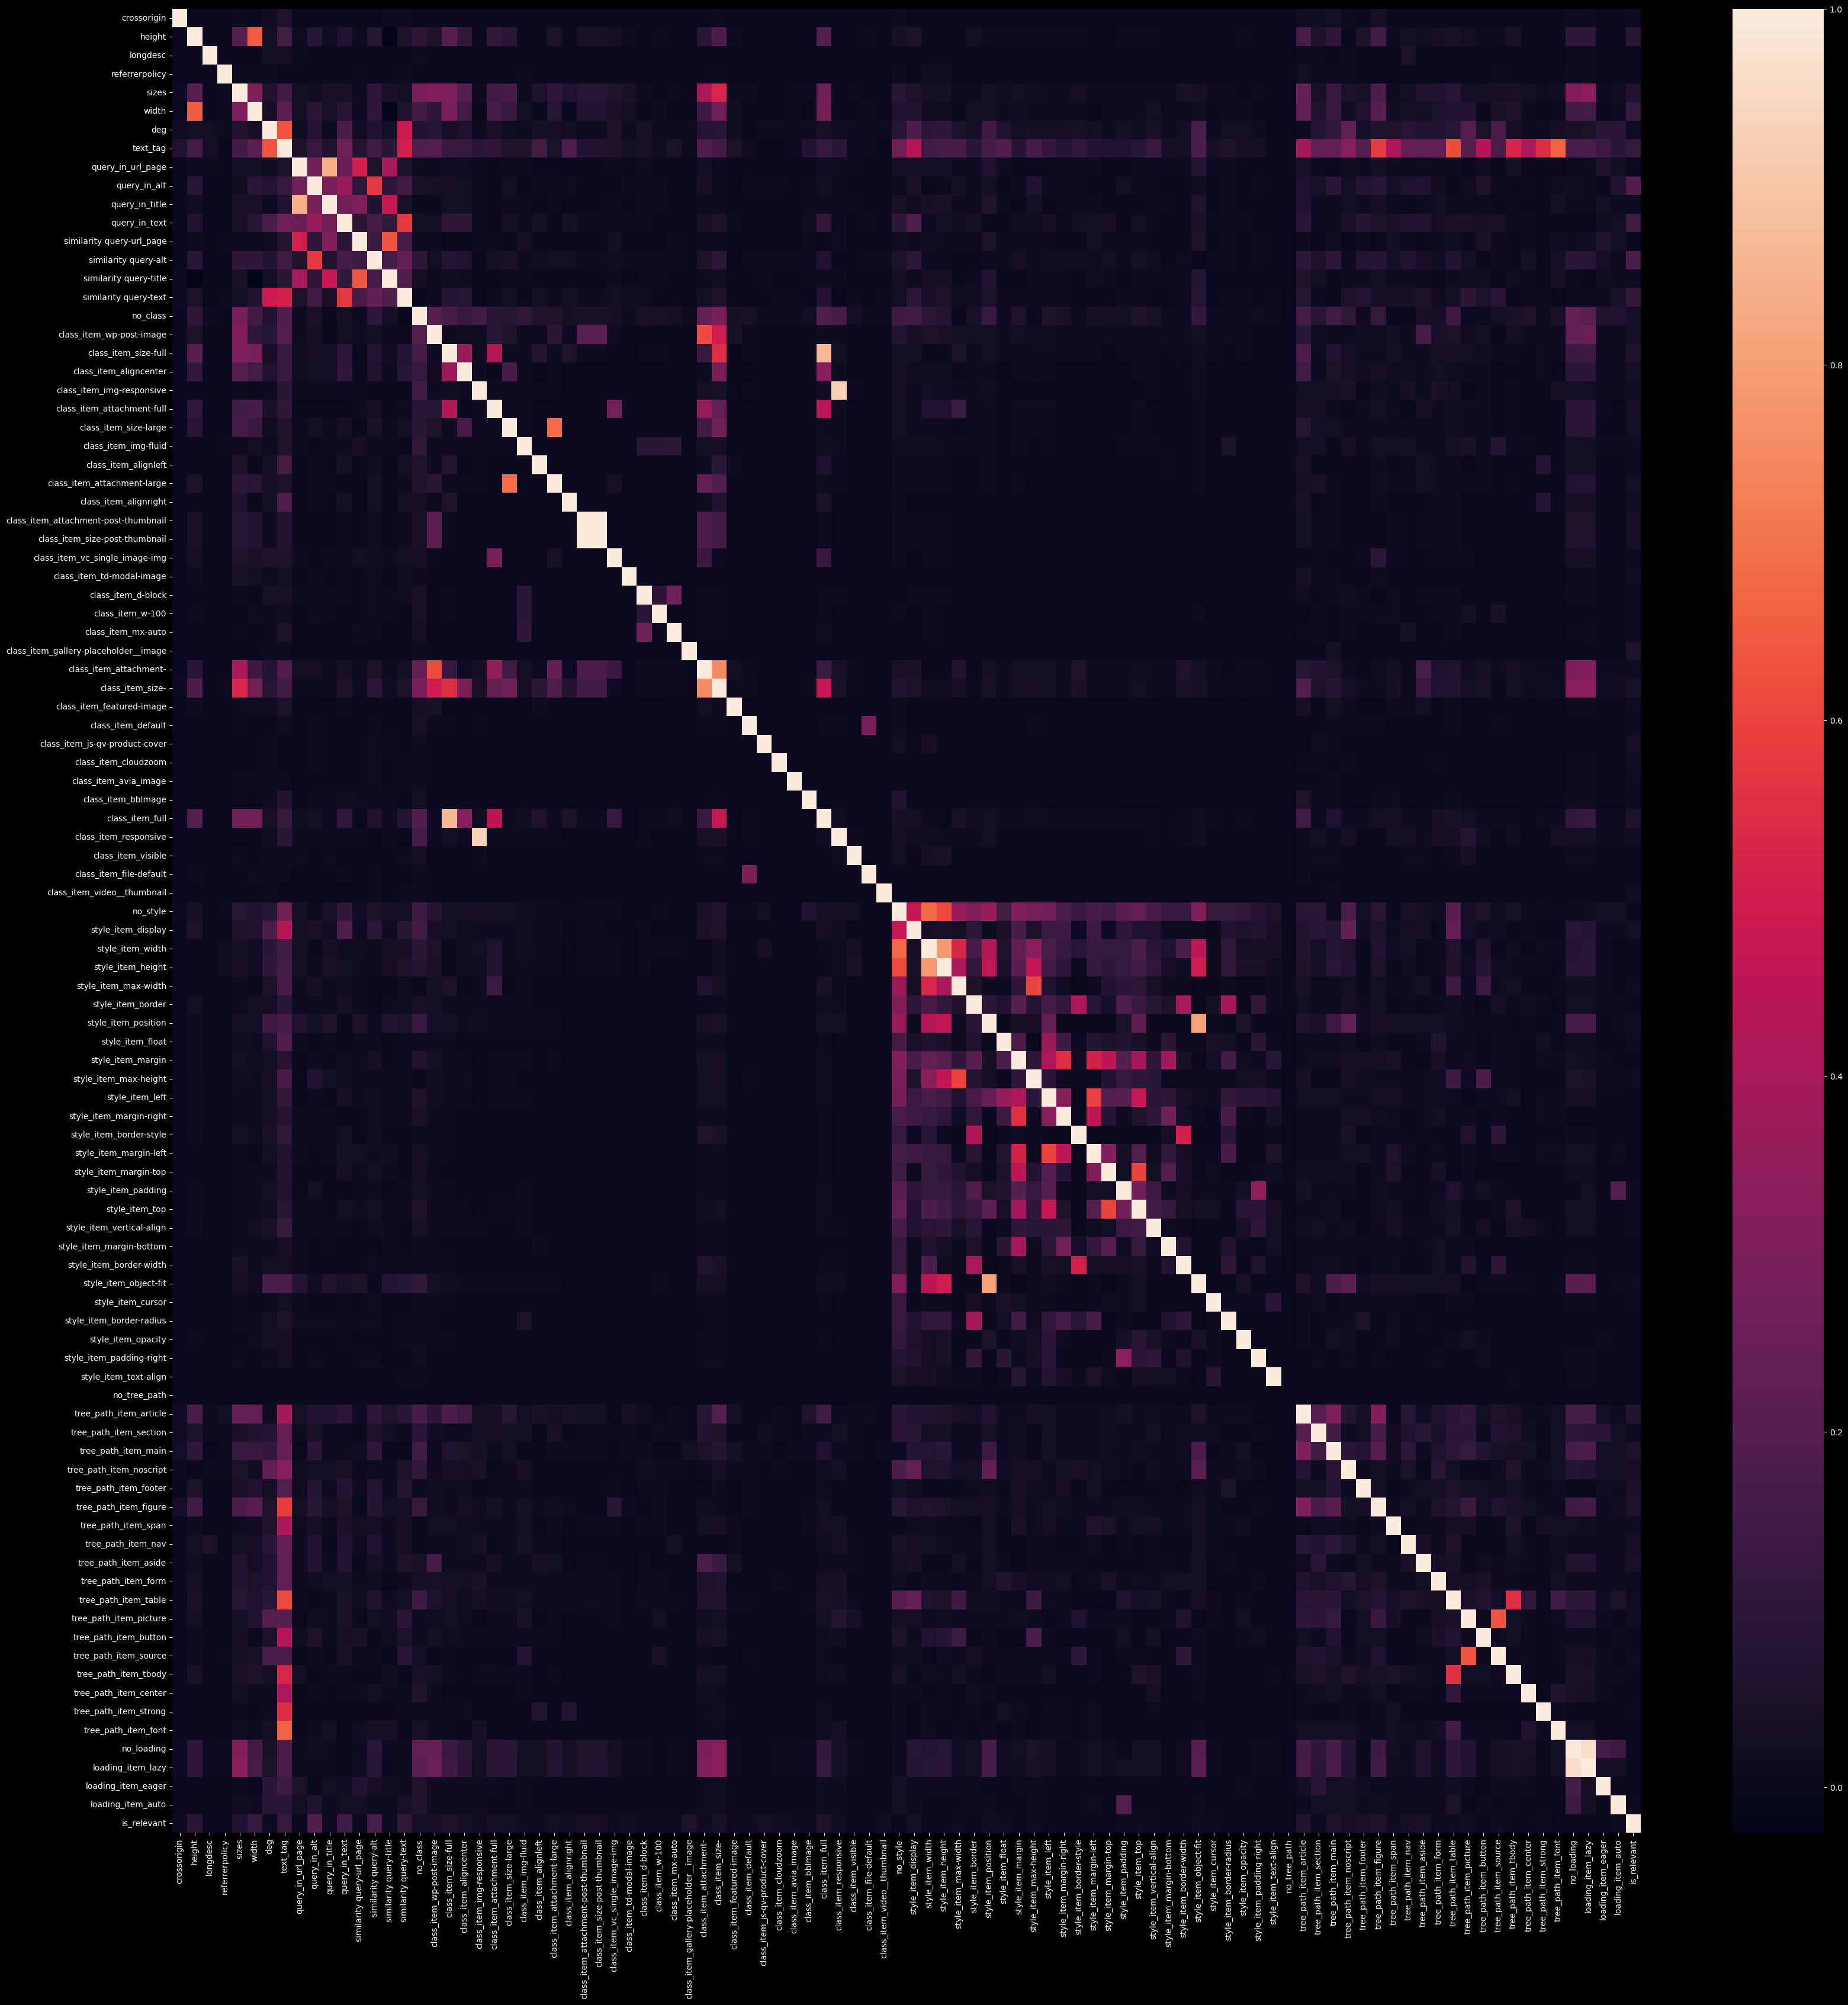

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(corr.astype(float), ax=ax)

This shows that some of the groups we created share some correlation (like different style or class items, or textual features)... that are somewhat low

## Runing and finetuning an estimator

Let us quickly run an Xboost algorithm on this dataset and measure the PR-AUC (cross-validated). PR-AUC is more indicated than ROC-AUC in the case of high class imbalance as is the case here as explained in [this article](https://towardsdatascience.com/imbalanced-data-stop-using-roc-auc-and-use-auprc-instead-46af4910a494). The range of values is the same but "good scores" can be lower (ROCAUC is bad if <.5 which would be random selection whereas PR-AUC is bad if < target-class rate)

XGBOOST is a good choice because it is compatible with high-dimensional datasets, large number of samples, it can handle NaNs natively

In [323]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, auc

# list of parameters available
# https://xgboost.readthedocs.io/en/stable/parameter.html and
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier

neg_items, pos_items = tmp3.is_relevant.value_counts().sort_index()
scale_pos_weight = neg_items / pos_items
print(f"scale_pos_weight={scale_pos_weight}")
assert scale_pos_weight > 10

xgb_parameters = {
    "device": "gpu",
    "verbosity": 2,
    "max_depth": 10,
    "max_leaves": 0,
    "scale_pos_weight": scale_pos_weight
    / 2,  # decreases performance for some reason when too high (experimentally)
    "objective": "binary:logistic",
    "eval_metric": ["auc", "error"],
    "enable_categorical": True,
    "random_state": 56789,
}

model = XGBClassifier(**xgb_parameters)


# strangely this is not natively implemented in sklearn
def pr_auc(estimator, X, y):
    """
    Computes the Precision-Recall AUC (more suited than ROC-AUC in the case
    of class-imbalance)
    """
    y_hat = estimator.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_hat)
    return auc(recall, precision)


# so that the algorithm can use these as categorical features out of the box, we need
# to use categories and not strings as with dython.
dtype_dict = {k: "category" if v == "str" else v for k, v in dtype_dict.items()}
X, y = tmp.astype(dtype_dict), df.is_relevant

# Evaluating using 5-fold CV for an overfitting-robust score.
mean_cv_score = cross_val_score(model, X, y, scoring=pr_auc, cv=5, n_jobs=3).mean()
print(f"cross-validation average PR-AUC={mean_cv_score}")

scale_pos_weight=26.835508540550443
cross-validation average PR-AUC=0.24557652764120483


In [328]:
# 25% is a rather low score, but higher than the default pos_items / df.shape[0]
# ~= 4% notice that roc-auc is about .86 (does not account for class-imbalance
# so much), but that bare-metal would be .5 (it can be as low as 0 but random
# predictions make it .5 in a balanced dataset) let us try a basic gridsearch to optimize the model's
# parameters

from sklearn.model_selection import GridSearchCV

gs_params = {
    "max_depth": [5, 8],
    "max_leaves": [0, 3, 10],
    "min_child_weight": [None, 1, 3],
    "gamma": [None, 0, 0.1],
    # "reg_alpha": [0, 0.001, 0.005, 0.01],
}
gs_clf = GridSearchCV(
    model, gs_params, scoring=pr_auc, cv=5, n_jobs=-1, verbose=10, error_score="raise"
)
gs_clf = gs_clf.fit(X, y)
results = (
    pd.DataFrame(gs_clf.cv_results_)[["mean_test_score", "params", "rank_test_score"]]
    .sort_values(by=["rank_test_score"])
    .head(10)
)
results

Fitting 5 folds for each of 54 candidates, totalling 270 fits


,mean_test_score,params,rank_test_score
47,0.260579,"{'gamma': 0.1, 'max_depth': 8, 'max_leaves': 0...",1
46,0.258809,"{'gamma': 0.1, 'max_depth': 8, 'max_leaves': 0...",2
45,0.258809,"{'gamma': 0.1, 'max_depth': 8, 'max_leaves': 0...",2
28,0.257896,"{'gamma': 0, 'max_depth': 8, 'max_leaves': 0, ...",4
27,0.257896,"{'gamma': 0, 'max_depth': 8, 'max_leaves': 0, ...",4
9,0.257896,"{'gamma': None, 'max_depth': 8, 'max_leaves': ...",4
10,0.257896,"{'gamma': None, 'max_depth': 8, 'max_leaves': ...",4
11,0.257579,"{'gamma': None, 'max_depth': 8, 'max_leaves': ...",8
29,0.257579,"{'gamma': 0, 'max_depth': 8, 'max_leaves': 0, ...",8
37,0.256318,"{'gamma': 0.1, 'max_depth': 5, 'max_leaves': 0...",10


In [329]:
# let us now measure training performance on the whole dataset and re-train the model on it so that it is suitable for predicting the test dataset
model = gs_clf.best_estimator_.fit(X,y)
yhat = model.predict(X)
bias = abs(yhat.sum() - y.sum()) / y.sum()
print(bias)
print(pr_auc(model, X, y))

2.2954618308375694
0.48628535529180356


## Prediction

In [330]:
# This is a rather high bias! It seems that the model find 3 times as much relevant images than there are in the train dataset.
del df, tmp2, tmp3, tmp4

In [341]:
# Now let us apply the results of the model to the test dataset
Xtest = pd.read_feather("test.feather")
with open("ctt_fitted.pickle", "rb") as f:
    ctt = pickle.load(f)

# could use an sklearn pipeline here to make things neater, but keeping things simple here.
Xtest = ctt.transform(Xtest)
Xtest = cct.transform(Xtest)
Xtest = cnt.transform(Xtest)
Xtest = ccrt.transform(Xtest)
Xtest = Xtest.astype(dtype_dict)
assert set(X.columns) == set(Xtest.columns)
Xtest

,crossorigin,height,longdesc,referrerpolicy,sizes,width,deg,text_tag,query_in_url_page,query_in_alt,...,tree_path_item_button,tree_path_item_source,tree_path_item_tbody,tree_path_item_center,tree_path_item_strong,tree_path_item_font,no_loading,loading_item_lazy,loading_item_eager,loading_item_auto
0,True,-1.048477,False,NaN,True,-0.754418,2.0,head,1,0,...,False,False,False,False,False,False,True,False,False,False
1,True,NaN,False,NaN,True,NaN,NaN,NaN,1,0,...,False,False,False,False,False,False,False,True,False,False
2,True,NaN,False,NaN,True,NaN,NaN,NaN,1,0,...,False,False,False,False,False,False,False,True,False,False
3,True,NaN,False,NaN,True,NaN,NaN,NaN,1,0,...,False,False,False,False,False,False,False,True,False,False
4,True,5.823997,False,NaN,True,6.666701,2.0,figure,1,0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210473,True,NaN,False,NaN,True,NaN,3.0,div,1,1,...,False,False,False,False,False,False,True,False,False,False
210474,True,NaN,False,NaN,True,NaN,NaN,NaN,1,0,...,False,False,False,False,False,False,True,False,False,False
210475,True,NaN,False,NaN,True,NaN,1.0,h5,1,0,...,False,False,False,False,False,False,True,False,False,False
210476,True,NaN,False,NaN,True,NaN,NaN,NaN,1,0,...,False,False,False,False,False,False,True,False,False,False


In [347]:
ytest_hat = model.predict(Xtest)
Xtest = pd.read_feather("test.feather")
submission = pd.DataFrame({"id":Xtest.id, "is_relevant":ytest_hat})
submission.to_csv("mysubmission.csv", index=False)
submission

,id,is_relevant
0,3096b43c6a60fc6da5bc699e22ea4d2c,0
1,2bab8dddb87218156b4fe970ec20e3c3,0
2,d56b5df3f79cfb8683f4495afb0e80f5,0
3,0fb07f912e2f50d5fafc3cd655da764a,0
4,69e661df59deb4c3dc78877cd1fcb97a,0
...,...,...
210473,6be3872dba69f28a4e35a0e193fb706e,0
210474,c5ba6fe44b3fd85a95b17f89efe17869,0
210475,52da253e46e480ae3c96ba8654ac5643,0
210476,be25e02ac1779fa9a75410aa53d714d1,0


## further steps
- Correlations were low: I wonder what's the current process to define which query is or is not relevant. Correlations were low with other variables, and from a human standpoint, just looking at the data it seemed hard to understand what was meaningful.
- It would be interesting to understand if some domains are more associated with a specific query embedding than others and have rules to prioritize some websites in some cases
- Is there really no more text surrounding the images we can exploit? I believe it would make complete sense to use a larger chunk of the article acompnaying the query
- It would be interesting to use the image as well for multimodal embedding and add come contraint on the size of the image. I don't understand how so many images don't even have the image height and width extracted (as it is independent from css). This image embedding can be compared to text embedding if both are in the same space (think yolo)
- The code could be made cleaner and more , more unit-tests written... But only after these previous steps